In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2
# The above two cell magic commands auto reloads the imported modules
# and uses the most current version. This is helpful is one makes changes to
# any of the imported modules code and wants to use the recently modified module.

In [3]:
import numpy as np
import pandas as pd
import scipy
import os

from progressbar import ProgressBar

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.15.0'

## 1.DATA:

In [4]:
data_path = 'drive/My Drive/DATA/HAR/timeseries/'

In [5]:
X_tr_path = data_path + 'tr_inertial_signals/'
X_ts_path  = data_path + 'ts_inertial_signals/'
y_tr_path = data_path + 'labels/y_train.txt'
y_ts_path  = data_path + 'labels/y_test.txt'

In [6]:
X_tr_path

'drive/My Drive/DATA/HAR/timeseries/tr_inertial_signals/'

In [7]:
def f_get_folder_content(folder):

    from pathlib import Path
    files_and_dirs = Path(folder).glob("*")

    return [i for i in files_and_dirs]

In [8]:
tr_paths = f_get_folder_content(X_tr_path)
ts_paths = f_get_folder_content(X_ts_path)

In [9]:
tr_paths

[PosixPath('drive/My Drive/DATA/HAR/timeseries/tr_inertial_signals/body_acc_x_train.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/tr_inertial_signals/body_acc_y_train.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/tr_inertial_signals/body_acc_z_train.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/tr_inertial_signals/body_gyro_x_train.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/tr_inertial_signals/body_gyro_y_train.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/tr_inertial_signals/body_gyro_z_train.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/tr_inertial_signals/total_acc_x_train.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/tr_inertial_signals/total_acc_y_train.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/tr_inertial_signals/total_acc_z_train.txt')]

In [10]:
ts_paths

[PosixPath('drive/My Drive/DATA/HAR/timeseries/ts_inertial_signals/body_acc_x_test.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/ts_inertial_signals/body_acc_y_test.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/ts_inertial_signals/body_acc_z_test.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/ts_inertial_signals/body_gyro_x_test.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/ts_inertial_signals/body_gyro_y_test.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/ts_inertial_signals/body_gyro_z_test.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/ts_inertial_signals/total_acc_x_test.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/ts_inertial_signals/total_acc_y_test.txt'),
 PosixPath('drive/My Drive/DATA/HAR/timeseries/ts_inertial_signals/total_acc_z_test.txt')]

## 2. CREATING MULTIVARIATE TIMESERIES DATASET FOR LSTM:

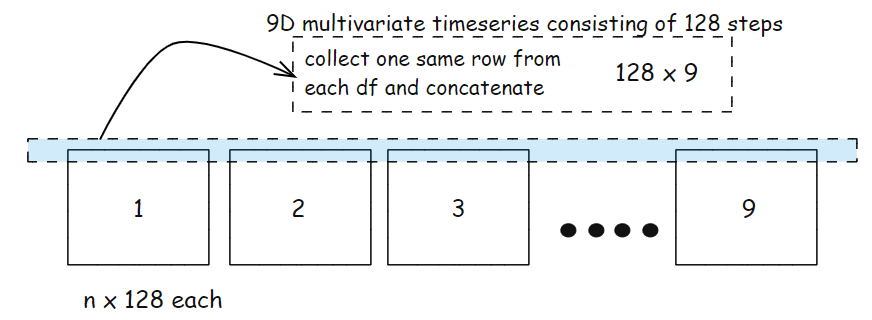

In [39]:
def f_create_lstm_dataset(paths):
    collect = []
    for i, p in enumerate(paths):
        df = pd.read_csv(paths[i], delim_whitespace=True, header=None)
        collect.append(df)

    df_lstm = pd.concat(collect, axis = 1)
    arr = [i.reshape(128, 9) for i in df_lstm.values] # 128 lg sequence of 9D vectors
    arr = [Normalizer().fit_transform(i) for i in arr] # Normalize each 128 seq of vectors
    return np.array(arr)

In [40]:
X_tr = f_create_lstm_dataset(tr_paths)
X_ts = f_create_lstm_dataset(ts_paths)

X_tr.shape, X_ts.shape

((7352, 128, 9), (2947, 128, 9))

In [41]:
y_tr = pd.read_csv(y_tr_path, delim_whitespace=True, header=None).values
y_ts = pd.read_csv(y_ts_path, delim_whitespace=True, header=None).values

y_tr.shape, y_ts.shape

((7352, 1), (2947, 1))

In [42]:
encoded_y_tr = pd.get_dummies(y_tr.flatten()).values * 1
encoded_y_ts = pd.get_dummies(y_ts.flatten()).values * 1

encoded_y_tr.shape, encoded_y_ts.shape

((7352, 6), (2947, 6))

In [43]:
encoded_y_tr

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

## 3.FUNCTION FOR GENERATING BATCHES:

In [44]:
def gen_batches(X, y, gen_constrain = False, n_EPOCHS = 2,
                      batch_size = 32):

    idxs = list(range(len(X)))

    c = 0
    while True:

        arryO_random_idxs = np.random.choice(idxs, batch_size, replace=False) # SAMPLE WITHOUT REPLACEMENT

        X_batch = X[arryO_random_idxs]
        y_batch = y[arryO_random_idxs]

        yield X_batch, y_batch

        if gen_constrain != False: # Keras expects an endless generator
                                   # Keras stops the generator internally by itself
                                   # use True if u want to check outputs for yourself
            c += 1
            if c >= n_EPOCHS:
                break

In [45]:
X, y = X_tr, encoded_y_tr
gen = gen_batches(X, y, gen_constrain = True, n_EPOCHS = 1, batch_size = 2)

batch = [i for i in gen]

In [46]:
batch

[(array([[[ 0.1790991 , -0.18939787, -0.13896369, ..., -0.42250046,
           -0.21321242, -0.43088695],
          [-0.18692758, -0.37432383, -0.50755489, ..., -0.03244837,
            0.14965631,  0.18628679],
          [ 0.33482785,  0.19822902, -0.09362089, ..., -0.0409468 ,
           -0.46243461, -0.7434134 ],
          ...,
          [-0.48311062, -0.49726521, -0.41191714, ..., -0.1745005 ,
           -0.321522  , -0.29270726],
          [-0.20623696, -0.24901805, -0.21309707, ..., -0.41706768,
           -0.47180848, -0.45089906],
          [-0.3610738 , -0.37732101, -0.40196663, ..., -0.31432841,
           -0.28483871, -0.20401733]],
  
         [[-0.55229086, -0.3617071 , -0.43680344, ..., -0.17497673,
           -0.12529472,  0.01888323],
          [ 0.63466165,  0.34357069,  0.51924876, ...,  0.21367468,
            0.23663273,  0.11151096],
          [-0.02609894, -0.00565292,  0.12749383, ...,  0.41795621,
            0.502141  ,  0.57355449],
          ...,
          [ 

In [47]:
batch[0][0].shape, batch[0][1].shape

((2, 128, 9), (2, 6))

## 4. FUNCTION FOR TRAINING / EVALUATING LSTM:

In [48]:
def fn_train_test_model(model, loss, optimizer, compile_metrics, monitor_metric,
                        X_train, y_train, X_val, y_val,
                        batch_size, n_epochs, model_save_path, verbose = 1):

    model.compile(loss = loss, optimizer = optimizer, metrics = compile_metrics)

    # DATA GENERATOR SPECS:
    train_data_generator = gen_batches(X_train, y_train, batch_size = batch_size)
    val_data_generator   = gen_batches(X_val , y_val, batch_size = batch_size)

    n_train_data_pts = len(X_train)
    n_test_data_pts  = len(X_val)
    n_steps_per_epoch  = n_train_data_pts//batch_size
    n_validation_steps = n_test_data_pts//batch_size

    # MODEL CALLBACKS:
    save_wts   = keras.callbacks.ModelCheckpoint(filepath = model_save_path,
                                                 monitor = monitor_metric,
                                                 save_best_only = True,
                                                 mode = 'max')
    callbacks_list = [save_wts]

    # FIT MODEL:
    model_history = model.fit(train_data_generator,
                              validation_data = val_data_generator,
                              verbose = verbose,
                              steps_per_epoch = n_steps_per_epoch,
                              validation_steps = n_validation_steps,
                              epochs = n_epochs,
                              callbacks = callbacks_list)

    return pd.DataFrame(model_history.history).sort_values(by = monitor_metric, ascending = False)

## 5. LSTM MODEL:

In [50]:
n_time_steps = 128
n_dims_per_timestep = 9
n_classes = 6

input_shape = (n_time_steps, n_dims_per_timestep)
kwargs = dict(kernel_initializer='glorot_normal', go_backwards=True)

model_lstm_1 = keras.models.Sequential()

model_lstm_1.add(keras.layers.LSTM(192, input_shape=input_shape, return_sequences=True, **kwargs))
model_lstm_1.add(keras.layers.BatchNormalization())
model_lstm_1.add(keras.layers.Dropout(0.2))

model_lstm_1.add(keras.layers.LSTM(192, input_shape=input_shape, return_sequences=True, **kwargs))
model_lstm_1.add(keras.layers.BatchNormalization())
model_lstm_1.add(keras.layers.Dropout(0.2))

model_lstm_1.add(keras.layers.LSTM(96,  return_sequences=True, **kwargs))
model_lstm_1.add(keras.layers.Dropout(0.2))
model_lstm_1.add(keras.layers.BatchNormalization())

model_lstm_1.add(keras.layers.LSTM(96,  return_sequences=True, **kwargs))
model_lstm_1.add(keras.layers.Dropout(0.2))
model_lstm_1.add(keras.layers.BatchNormalization())

model_lstm_1.add(keras.layers.LSTM(64,  return_sequences=True, **kwargs))
model_lstm_1.add(keras.layers.Dropout(0.2))
model_lstm_1.add(keras.layers.BatchNormalization())

model_lstm_1.add(keras.layers.LSTM(32,  return_sequences=True, **kwargs))
model_lstm_1.add(keras.layers.Dropout(0.2))
model_lstm_1.add(keras.layers.BatchNormalization())

model_lstm_1.add(keras.layers.LSTM(32,  return_sequences=True, **kwargs))
model_lstm_1.add(keras.layers.Dropout(0.2))
model_lstm_1.add(keras.layers.BatchNormalization())

model_lstm_1.add(keras.layers.LSTM(12,  return_sequences=False, **kwargs))
model_lstm_1.add(keras.layers.Dropout(0.2))
model_lstm_1.add(keras.layers.BatchNormalization())


model_lstm_1.add(keras.layers.Dense(n_classes, activation = 'softmax'))

model_lstm_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 192)          155136    
                                                                 
 batch_normalization (Batch  (None, 128, 192)          768       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128, 192)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128, 192)          295680    
                                                                 
 batch_normalization_1 (Bat  (None, 128, 192)          768       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128, 192)         

## 6. TRAINING LSTM MODEL:

In [51]:
save_path = 'drive/My Drive/DATA/HAR/models/'

In [52]:
model = model_lstm_1

loss='categorical_crossentropy'
optimizer = keras.optimizers.RMSprop(learning_rate = 1e-3)
compile_metrics=['accuracy']
monitor_metric = 'val_accuracy'

X_train, y_train = X_tr, encoded_y_tr
X_val, y_val = X_ts, encoded_y_ts
batch_size = 100
n_epochs = 150

model_save_path = save_path + 'model_1-{epoch:02d}-{val_accuracy:.4f}.keras'

df_perf_model_1_1 = fn_train_test_model(model, loss, optimizer,
                                        compile_metrics, monitor_metric,
                                        X_train, y_train, X_val, y_val,
                                        batch_size, n_epochs, model_save_path)

Epoch 1/150
73/73 [==============================] - 25s 119ms/step - loss: 1.5027 - accuracy: 0.3708 - val_loss: 1.7113 - val_accuracy: 0.2838
Epoch 2/150
73/73 [==============================] - 6s 78ms/step - loss: 1.2843 - accuracy: 0.4511 - val_loss: 1.9442 - val_accuracy: 0.1779
Epoch 3/150
73/73 [==============================] - 5s 74ms/step - loss: 1.1763 - accuracy: 0.4962 - val_loss: 2.3508 - val_accuracy: 0.1348
Epoch 4/150
73/73 [==============================] - 6s 79ms/step - loss: 1.0443 - accuracy: 0.5510 - val_loss: 2.3370 - val_accuracy: 0.2307
Epoch 5/150
73/73 [==============================] - 6s 79ms/step - loss: 0.9715 - accuracy: 0.5847 - val_loss: 2.3352 - val_accuracy: 0.3224
Epoch 6/150
73/73 [==============================] - 6s 79ms/step - loss: 0.9159 - accuracy: 0.6119 - val_loss: 2.6007 - val_accuracy: 0.2890
Epoch 7/150
73/73 [==============================] - 6s 79ms/step - loss: 0.8247 - accuracy: 0.6682 - val_loss: 2.3247 - val_accuracy: 0.3400
Epoc

In [53]:
df_perf_model_1_1.sort_values(by = 'val_accuracy', ascending = False)[:3]

,loss,accuracy,val_loss,val_accuracy
141,0.013613,0.997945,0.883890,0.910345
113,0.020552,0.994932,0.639860,0.909655
134,0.021546,0.995068,0.682358,0.908966


In [54]:
optimizer = keras.optimizers.RMSprop(learning_rate = 1e-4)

model_save_path = save_path + 'model_1_2-{epoch:02d}-{val_accuracy:.4f}.keras'

df_perf_model_1_2 = fn_train_test_model(model, loss, optimizer,
                                        compile_metrics, monitor_metric,
                                        X_train, y_train, X_val, y_val,
                                        batch_size, n_epochs, model_save_path)

Epoch 1/150
73/73 [==============================] - 23s 117ms/step - loss: 0.0091 - accuracy: 0.9988 - val_loss: 0.8839 - val_accuracy: 0.8897
Epoch 2/150
73/73 [==============================] - 6s 78ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.7877 - val_accuracy: 0.9028
Epoch 3/150
73/73 [==============================] - 6s 79ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.8196 - val_accuracy: 0.9003
Epoch 4/150
73/73 [==============================] - 6s 76ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.7270 - val_accuracy: 0.9079
Epoch 5/150
73/73 [==============================] - 6s 81ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.8112 - val_accuracy: 0.8986
Epoch 6/150
73/73 [==============================] - 6s 79ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.8247 - val_accuracy: 0.8955
Epoch 7/150
73/73 [==============================] - 5s 74ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.7768 - val_accuracy: 0.9041
Epoc

In [55]:
df_perf_model_1_2.sort_values(by = 'val_accuracy', ascending = False)[:3]

,loss,accuracy,val_loss,val_accuracy
97,0.000684,0.999589,0.855622,0.923448
79,0.001185,0.999589,0.831005,0.923103
88,0.000693,0.999726,0.909146,0.920690


In [67]:
optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)

model_save_path = save_path + 'model_1_3-{epoch:02d}-{val_accuracy:.4f}.keras'

df_perf_model_1_3 = fn_train_test_model(model, loss, optimizer,
                                        compile_metrics, monitor_metric,
                                        X_train, y_train, X_val, y_val,
                                        batch_size, n_epochs, model_save_path)

Epoch 1/150
73/73 [==============================] - 24s 122ms/step - loss: 6.5507e-04 - accuracy: 0.9999 - val_loss: 1.0660 - val_accuracy: 0.9093
Epoch 2/150
73/73 [==============================] - 6s 85ms/step - loss: 5.8180e-04 - accuracy: 0.9999 - val_loss: 1.1417 - val_accuracy: 0.9066
Epoch 3/150
73/73 [==============================] - 5s 75ms/step - loss: 5.6039e-04 - accuracy: 0.9999 - val_loss: 1.0665 - val_accuracy: 0.9128
Epoch 4/150
73/73 [==============================] - 6s 82ms/step - loss: 5.3790e-04 - accuracy: 0.9999 - val_loss: 1.0451 - val_accuracy: 0.9124
Epoch 5/150
73/73 [==============================] - 6s 76ms/step - loss: 5.3004e-04 - accuracy: 1.0000 - val_loss: 1.1235 - val_accuracy: 0.9100
Epoch 6/150
73/73 [==============================] - 6s 80ms/step - loss: 9.2463e-04 - accuracy: 0.9997 - val_loss: 1.1716 - val_accuracy: 0.9038
Epoch 7/150
73/73 [==============================] - 6s 87ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 1.1057 - v

In [68]:
df_perf_model_1_3.sort_values(by = 'val_accuracy', ascending = False)[:3]

,loss,accuracy,val_loss,val_accuracy
7,0.000474,0.999863,0.898268,0.924828
12,0.000364,1.000000,0.872045,0.923793
107,0.000406,1.000000,0.934132,0.922759


In [69]:
optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)

model_save_path = save_path + 'model_1_4-{epoch:02d}-{val_accuracy:.4f}.keras'

df_perf_model_1_4 = fn_train_test_model(model, loss, optimizer,
                                        compile_metrics, monitor_metric,
                                        X_train, y_train, X_val, y_val,
                                        batch_size, n_epochs, model_save_path)

Epoch 1/150
73/73 [==============================] - 22s 119ms/step - loss: 5.8640e-04 - accuracy: 0.9999 - val_loss: 1.1084 - val_accuracy: 0.9066
Epoch 2/150
73/73 [==============================] - 6s 82ms/step - loss: 5.2583e-04 - accuracy: 0.9999 - val_loss: 1.1385 - val_accuracy: 0.9103
Epoch 3/150
73/73 [==============================] - 6s 86ms/step - loss: 5.0284e-04 - accuracy: 0.9999 - val_loss: 1.0674 - val_accuracy: 0.9121
Epoch 4/150
73/73 [==============================] - 6s 83ms/step - loss: 7.8816e-04 - accuracy: 0.9997 - val_loss: 1.0319 - val_accuracy: 0.9169
Epoch 5/150
73/73 [==============================] - 6s 86ms/step - loss: 2.0388e-04 - accuracy: 1.0000 - val_loss: 1.1634 - val_accuracy: 0.9045
Epoch 6/150
73/73 [==============================] - 6s 80ms/step - loss: 3.8120e-04 - accuracy: 0.9999 - val_loss: 1.0988 - val_accuracy: 0.9141
Epoch 7/150
73/73 [==============================] - 6s 78ms/step - loss: 4.1586e-04 - accuracy: 1.0000 - val_loss: 1.0549

In [70]:
df_perf_model_1_4.sort_values(by = 'val_accuracy', ascending = False)[:3]

,loss,accuracy,val_loss,val_accuracy
28,0.000559,1.000000,0.953820,0.922414
112,0.000280,0.999863,0.922697,0.921379
50,0.000404,0.999863,0.996908,0.921034


In [71]:
optimizer = keras.optimizers.RMSprop(learning_rate = 1e-3)

model_save_path = save_path + 'model_1_5-{epoch:02d}-{val_accuracy:.4f}.keras'

df_perf_model_1_5 = fn_train_test_model(model, loss, optimizer,
                                        compile_metrics, monitor_metric,
                                        X_train, y_train, X_val, y_val,
                                        batch_size, n_epochs, model_save_path)

Epoch 1/150
73/73 [==============================] - 23s 119ms/step - loss: 5.7243e-04 - accuracy: 0.9999 - val_loss: 1.1322 - val_accuracy: 0.9076
Epoch 2/150
73/73 [==============================] - 6s 79ms/step - loss: 3.9707e-04 - accuracy: 1.0000 - val_loss: 1.1081 - val_accuracy: 0.9086
Epoch 3/150
73/73 [==============================] - 6s 81ms/step - loss: 3.0538e-04 - accuracy: 1.0000 - val_loss: 1.2072 - val_accuracy: 0.9072
Epoch 4/150
73/73 [==============================] - 6s 81ms/step - loss: 3.0636e-04 - accuracy: 1.0000 - val_loss: 1.1291 - val_accuracy: 0.9117
Epoch 5/150
73/73 [==============================] - 6s 81ms/step - loss: 9.9596e-04 - accuracy: 0.9996 - val_loss: 1.3116 - val_accuracy: 0.8997
Epoch 6/150
73/73 [==============================] - 6s 88ms/step - loss: 3.2962e-04 - accuracy: 1.0000 - val_loss: 1.2699 - val_accuracy: 0.9038
Epoch 7/150
73/73 [==============================] - 5s 72ms/step - loss: 3.6187e-04 - accuracy: 0.9999 - val_loss: 1.3038

In [72]:
df_perf_model_1_5.sort_values(by = 'val_accuracy', ascending = False)[:3]

,loss,accuracy,val_loss,val_accuracy
87,0.004391,0.998630,0.784532,0.920000
78,0.006073,0.998630,0.691002,0.916897
106,0.009095,0.997945,0.691701,0.916552


In [73]:
optimizer = keras.optimizers.RMSprop(learning_rate = 1e-4, momentum = 0.9)

n_epochs = 150
model_save_path = save_path + 'model_1_6-{epoch:02d}-{val_accuracy:.4f}.keras'

df_perf_model_1_6 = fn_train_test_model(model, loss, optimizer,
                                        compile_metrics, monitor_metric,
                                        X_train, y_train, X_val, y_val,
                                        batch_size, n_epochs, model_save_path)

Epoch 1/150
73/73 [==============================] - 25s 128ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 1.0032 - val_accuracy: 0.9028
Epoch 2/150
73/73 [==============================] - 6s 84ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 1.0667 - val_accuracy: 0.9034
Epoch 3/150
73/73 [==============================] - 6s 81ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 1.2036 - val_accuracy: 0.8983
Epoch 4/150
73/73 [==============================] - 6s 81ms/step - loss: 0.0185 - accuracy: 0.9973 - val_loss: 1.1831 - val_accuracy: 0.8962
Epoch 5/150
73/73 [==============================] - 6s 80ms/step - loss: 0.0114 - accuracy: 0.9975 - val_loss: 0.9578 - val_accuracy: 0.9031
Epoch 6/150
73/73 [==============================] - 6s 83ms/step - loss: 0.0076 - accuracy: 0.9988 - val_loss: 0.9089 - val_accuracy: 0.9055
Epoch 7/150
73/73 [==============================] - 6s 86ms/step - loss: 0.0055 - accuracy: 0.9988 - val_loss: 1.0161 - val_accuracy: 0.9034
Epoc

In [74]:
df_perf_model_1_6.sort_values(by = 'val_accuracy', ascending = False)[:3]

,loss,accuracy,val_loss,val_accuracy
104,0.005143,0.999041,0.835949,0.928621
110,0.006648,0.998904,0.804524,0.927586
30,0.005020,0.998904,0.763674,0.925172


In [75]:
optimizer = keras.optimizers.RMSprop(learning_rate = 1e-4, momentum = 0.9)

n_epochs = 150
model_save_path = save_path + 'model_1_7-{epoch:02d}-{val_accuracy:.4f}.keras'

df_perf_model_1_7 = fn_train_test_model(model, loss, optimizer,
                                        compile_metrics, monitor_metric,
                                        X_train, y_train, X_val, y_val,
                                        batch_size, n_epochs, model_save_path)

Epoch 1/150
73/73 [==============================] - 23s 122ms/step - loss: 0.0047 - accuracy: 0.9993 - val_loss: 1.0757 - val_accuracy: 0.8986
Epoch 2/150
73/73 [==============================] - 6s 84ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 1.0219 - val_accuracy: 0.9159
Epoch 3/150
73/73 [==============================] - 7s 90ms/step - loss: 0.0072 - accuracy: 0.9989 - val_loss: 0.7071 - val_accuracy: 0.9217
Epoch 4/150
73/73 [==============================] - 6s 84ms/step - loss: 0.0086 - accuracy: 0.9979 - val_loss: 0.7729 - val_accuracy: 0.9231
Epoch 5/150
73/73 [==============================] - 6s 89ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.8694 - val_accuracy: 0.9134
Epoch 6/150
73/73 [==============================] - 6s 81ms/step - loss: 6.1723e-04 - accuracy: 0.9999 - val_loss: 0.9465 - val_accuracy: 0.9148
Epoch 7/150
73/73 [==============================] - 6s 79ms/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 1.1857 - val_accuracy: 0.9045


In [76]:
df_perf_model_1_7.sort_values(by = 'val_accuracy', ascending = False)[:3]

,loss,accuracy,val_loss,val_accuracy
95,0.006517,0.998904,0.797116,0.928966
42,0.003089,0.998904,0.848407,0.924828
41,0.008998,0.998630,0.872570,0.924483


In [77]:
optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5, momentum = 0.9)

n_epochs = 150
model_save_path = save_path + 'model_1_8-{epoch:02d}-{val_accuracy:.4f}.keras'

df_perf_model_1_8 = fn_train_test_model(model, loss, optimizer,
                                        compile_metrics, monitor_metric,
                                        X_train, y_train, X_val, y_val,
                                        batch_size, n_epochs, model_save_path)

Epoch 1/150
73/73 [==============================] - 24s 121ms/step - loss: 7.2120e-04 - accuracy: 0.9999 - val_loss: 0.9620 - val_accuracy: 0.9148
Epoch 2/150
73/73 [==============================] - 6s 83ms/step - loss: 3.5067e-04 - accuracy: 1.0000 - val_loss: 1.1131 - val_accuracy: 0.9041
Epoch 3/150
73/73 [==============================] - 5s 74ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.9883 - val_accuracy: 0.9141
Epoch 4/150
73/73 [==============================] - 6s 80ms/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 1.0915 - val_accuracy: 0.9059
Epoch 5/150
73/73 [==============================] - 6s 81ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 1.0339 - val_accuracy: 0.9138
Epoch 6/150
73/73 [==============================] - 6s 89ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 1.0745 - val_accuracy: 0.9128
Epoch 7/150
73/73 [==============================] - 6s 81ms/step - loss: 2.5878e-04 - accuracy: 1.0000 - val_loss: 1.1162 - val_accuracy:

In [78]:
df_perf_model_1_8.sort_values(by = 'val_accuracy', ascending = False)[:3]

,loss,accuracy,val_loss,val_accuracy
96,0.000130,1.000000,1.094548,0.923448
20,0.000513,0.999863,0.968370,0.922414
144,0.001028,0.999726,1.156274,0.921724


### FN TO VISUALIZE MODEL PERFORMANCE:

In [56]:
def f_confusion_matrix(y, y_pred, listO_classes):

    con_matrix = confusion_matrix(y, y_pred)
    df_confusion_matrix = pd.DataFrame(con_matrix)

    df_confusion_matrix.columns = ['pred_' + str(i) for i in listO_classes]
    df_confusion_matrix.index = ['actual_' + str(i) for i in listO_classes]

    actual_total = con_matrix.sum(axis = 1)
    pred_total = con_matrix.sum(axis = 0)
    correct_preds = con_matrix.diagonal()

    df_confusion_matrix = df_confusion_matrix.assign(correct_preds = correct_preds,
                                                     pred_total    = pred_total,
                                                     actual_total  = actual_total)
    precision = correct_preds/pred_total
    recall = correct_preds/actual_total
    f1_score = (2*precision*recall)/(precision + recall)

    df_confusion_matrix = df_confusion_matrix.assign(precision=precision, recall=recall, f1_score = f1_score)

    return df_confusion_matrix

In [57]:
def f_heatmap_precision_recall_matrix(df_con_matrix):

    def f_precison_matrix(df_con_matrix):
        listO_rows = []
        for row in df_con_matrix.iloc[:, :-6].values:
            new_row = row/df_con_matrix.pred_total
            listO_rows.append(new_row)
        df_precision_matrix = pd.DataFrame(np.array(listO_rows))
        return df_precision_matrix

    def f_recall_matrix(df_con_matrix):
        listO_rows = []
        for row in df_con_matrix.iloc[:, :-6].T.values:
            new_row = row/df_con_matrix.actual_total
            listO_rows.append(new_row)
        df_recall_matrix = pd.DataFrame(np.array(listO_rows))
        return df_recall_matrix


    df_precision_matrix = f_precison_matrix(df_con_matrix)
    df_recall_matrix = f_recall_matrix(df_con_matrix)

    labels = list(range(1, len(df_con_matrix)+1))
    sns.set(font_scale=1.05)
    cmap = sns.dark_palette("muted purple", input="xkcd")

    print("PRECISION MATRIX :")
    print()
    plt.figure(figsize=(17 ,4))
    sns.heatmap(df_precision_matrix, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('y_PRED')
    plt.ylabel('% ACTUAL CLASSES')
    plt.show()

    print("RECALL MATRIX :")
    print()
    plt.figure(figsize=(17 ,4))
    sns.heatmap(df_recall_matrix, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('y_ACTUAL')
    plt.ylabel('% PREDICTED CLASSES')
    plt.show()

## LOADING BEST LSTM MODEL:

In [58]:
best_lstm_model = keras.models.load_model(save_path + 'model_1_2-98-0.9234.keras')

best_lstm_model

In [60]:
y_pred = best_lstm_model.predict(X_ts)
y_pred

93/93 [==============================] - 4s 19ms/step


array([[4.96342256e-09, 7.97462274e-09, 8.31875102e-09, 2.10148301e-07,
        9.99999762e-01, 1.43615368e-08],
       [5.71782355e-09, 1.13302674e-08, 1.04028315e-08, 3.01326537e-07,
        9.99999642e-01, 1.86828029e-08],
       [5.65085312e-09, 1.10194600e-08, 9.96771643e-09, 2.82323299e-07,
        9.99999642e-01, 1.74823107e-08],
       ...,
       [7.66942510e-10, 1.00000000e+00, 4.91728924e-09, 1.39910972e-08,
        2.51979215e-09, 8.33485336e-10],
       [9.58576662e-10, 1.00000000e+00, 4.92774888e-09, 1.50681423e-08,
        3.11670156e-09, 1.01165576e-09],
       [1.46182200e-09, 1.00000000e+00, 6.61948629e-09, 2.06544826e-08,
        4.84392615e-09, 1.31143651e-09]], dtype=float32)

In [61]:
y_preD = np.array([list(i).index(i.max()) for i in y_pred]).reshape(-1, 1)
y_preD.shape

(2947, 1)

In [79]:
y_ts.shape

(2947, 1)

***

## MODEL PERFORMANCE :

In [65]:
listO_classes = 'walk walk_U walk_D sit stand lay'.split()

df_con_matrix = f_confusion_matrix(list(y_ts.flatten()), list(y_preD.flatten()+1), listO_classes)
df_con_matrix

,pred_walk,pred_walk_U,pred_walk_D,pred_sit,pred_stand,pred_lay,correct_preds,pred_total,actual_total,precision,recall,f1_score
actual_walk,466,11,17,2,0,0,466,482,496,0.966805,0.939516,0.952965
actual_walk_U,9,441,17,3,1,0,441,473,471,0.932347,0.936306,0.934322
actual_walk_D,7,20,393,0,0,0,393,427,420,0.920375,0.935714,0.927981
actual_sit,0,0,0,393,98,0,393,470,491,0.836170,0.800407,0.817898
actual_stand,0,1,0,72,459,0,459,558,532,0.822581,0.862782,0.842202
actual_lay,0,0,0,0,0,537,537,537,537,1.000000,1.000000,1.000000


PRECISION MATRIX :



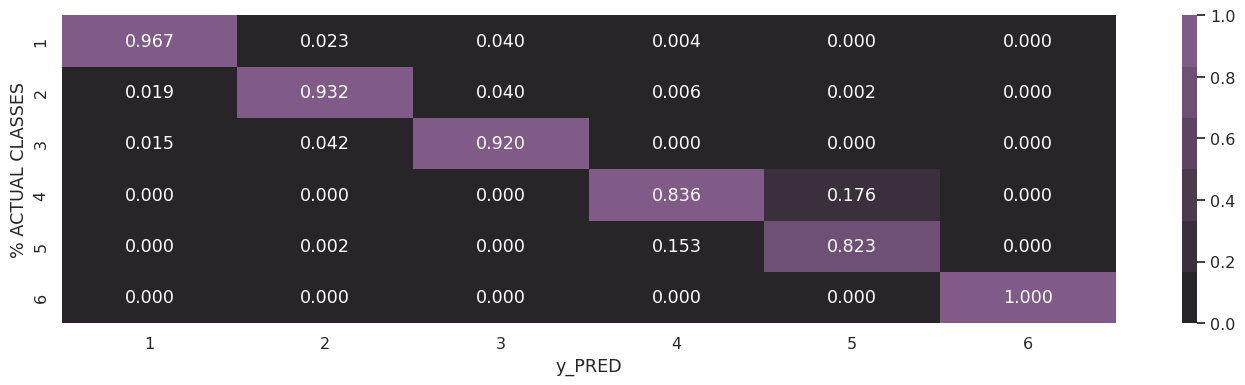

RECALL MATRIX :



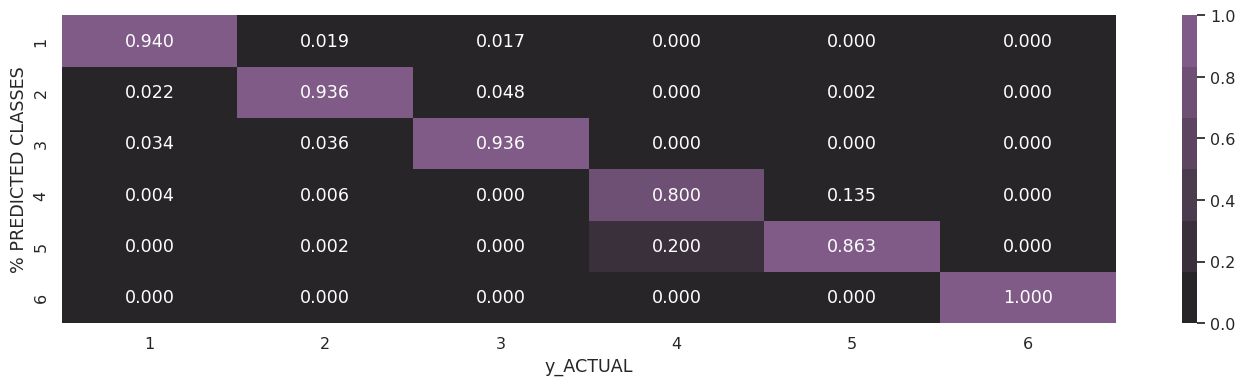

In [66]:
f_heatmap_precision_recall_matrix(df_con_matrix)

***